### Ejercicio 3 Distribución de vacunas

Una compañía distribuidora de vacunas dispone de un total de un millón de vacunas para repartir en España. Las vacunas llegan a través del aeropuero de Madrid-Barajas, por lo que tienen un coste asociado al transporte hasta el lugar de su utilización (en euros por dosis). Cada comunidad autónoma (región) tiene un número de individuos susceptibles de ser vacunados y realiza una oferta por dosis de vacuna (en euros por dosis). El requisito del Gobierno para que se comercialicen las vacunas es que al menos se vacune al 5% de la población susceptible en cada territorio. ¿Cuál es el beneficio máximo que puede obtener la empresa? Los datos por comunidades autónomas están recogidos en el Excel adjunto “DatosVacunas.xlsx”.

$$
\begin{align}
	&\text{max }  &&  \sum_{r} (Precio_r-Trans_r)V_r  &&\\
	&\text{s.t. }  && \sum_{r}V_r    \le  1000000\\
	&  && V_r \ge  0.05Susc_r\\
    &  && V_r\le Susc_r \\
    & && V_r \geq  0  \\
\end{align}
$$

In [1]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model=ConcreteModel()

In [3]:
df = pd.read_excel('DatosVacunas.xlsx')
df

,Región,Individuos_susceptibles,Pagan,Transporte
0,Aragon,322000,57,3.2
1,Asturias,111000,27,5.7
2,Baleares,141000,13,14.4
3,Canarias,63000,52,24.7
4,Cantabria,77000,51,5.1
5,CastillaLeon,451000,39,3.1
6,CastillaLaMancha,487000,96,2.4
7,Cataluña,822000,59,6.3
8,ComValenciana,744000,77,4.5
9,Extremadura,156000,82,5.3


In [4]:
df.loc[11,'Pagan'] #selección de un elemento

37

In [5]:
df['Pagan'][11]

37

In [6]:
df['Pagan'][:]
b=df['Pagan'][:]
b

0     57
1     27
2     13
3     52
4     51
5     39
6     96
7     59
8     77
9     82
10    45
11    37
12    66
13    69
14    92
15    43
16    78
17    71
Name: Pagan, dtype: int64

In [7]:
df.loc[:,'Región'] #selección de una columna

0               Aragon
1             Asturias
2             Baleares
3             Canarias
4            Cantabria
5         CastillaLeon
6     CastillaLaMancha
7             Cataluña
8        ComValenciana
9          Extremadura
10             Galicia
11           ComMadrid
12              Murcia
13             Navarra
14           PaisVasco
15               Rioja
16               Ceuta
17             Melilla
Name: Región, dtype: object

In [8]:
df.loc[11,:] #selección de una fila
a=df.loc[11:13,:]
a

,Región,Individuos_susceptibles,Pagan,Transporte
11,ComMadrid,899000,37,0.0
12,Murcia,201000,66,6.1
13,Navarra,341000,69,4.9


In [9]:
df[11:] #selección de filas

,Región,Individuos_susceptibles,Pagan,Transporte
11,ComMadrid,899000,37,0.0
12,Murcia,201000,66,6.1
13,Navarra,341000,69,4.9
14,PaisVasco,406000,92,5.9
15,Rioja,233000,43,4.1
16,Ceuta,51000,78,10.1
17,Melilla,37000,71,10.7


In [10]:
df.shape #tamaño del df

(18, 4)

In [11]:
df.set_index('Región', inplace=True) #reemplaza el index en el df actual
df

,Individuos_susceptibles,Pagan,Transporte
Región,,,
Aragon,322000,57,3.2
Asturias,111000,27,5.7
Baleares,141000,13,14.4
Canarias,63000,52,24.7
Cantabria,77000,51,5.1
CastillaLeon,451000,39,3.1
CastillaLaMancha,487000,96,2.4
Cataluña,822000,59,6.3
ComValenciana,744000,77,4.5


In [12]:
1000000/df['Individuos_susceptibles'].sum()

0.1712035610340695

In [13]:
model.r=Set(initialize=df.index)

model.vacregion=Var(model.r,within=NonNegativeReals)

dosis_disp=1000000

#def vac_total(model):
#    return sum(model.vacregion[r] for r in model.r)<=dosis_disp
#model.vactotal=Constraint(rule=vac_total)

model.vactotal=Constraint(expr=sum(model.vacregion[r] for r in model.r)<=dosis_disp)

def min_vac(model,r):
    return model.vacregion[r]>=0.05*df['Individuos_susceptibles'][r]
model.minvac=Constraint(model.r,rule=min_vac)

#model.constlist = ConstraintList()
#for r in model.r:
#    model.constlist.add(model.vacregion[r]>=0.05*df['Individuos_susceptibles'][r])


def max_vac(model,r):
    return model.vacregion[r]<=df['Individuos_susceptibles'][r]
model.maxvac=Constraint(model.r,rule=max_vac)

def benef(model):
    return sum(model.vacregion[r]*(df['Pagan'][r]-df['Transporte'][r]) for r in model.r)
model.obj = Objective(rule = benef, sense=maximize)

results_cost = SolverFactory('glpk').solve(model).write()
model.pprint()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 80593505.0
  Upper bound: 80593505.0
  Number of objectives: 1
  Number of constraints: 38
  Number of variables: 19
  Number of nonzeros: 55
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.03892326354980469
# ----------------------------------------------------------
#   Solution Information
# ------------------------

#### Se desea analizar cómo influye el porcentaje mínimo de individuos vacunados

In [14]:
def efecto_madrid(minimovac):
    def min_vac2(model,r):
        return model.vacregion[r]>=minimovac*df['Individuos_susceptibles'][r]
    model.minvac.deactivate()  
    model.minvac2=Constraint(model.r,rule=min_vac2)
    results_cost = SolverFactory('glpk').solve(model).write()
    return model.vacregion,model.obj();  


In [15]:
vac,objec=efecto_madrid(0.05)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 80593505.0
  Upper bound: 80593505.0
  Number of objectives: 1
  Number of constraints: 38
  Number of variables: 19
  Number of nonzeros: 55
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.035902976989746094
# ----------------------------------------------------------
#   Solution Information
# -----------------------

In [16]:
type(vac)

pyomo.core.base.var.IndexedVar

In [17]:
j=np.arange(0,0.17,0.01)
Madrid=[]
CastillaLaMancha=[]
PaisVasco =[]
Objetivo=[]
for i in j:
    print(i)
    n,obj=efecto_madrid(i)
    Madrid.append(value(n['ComMadrid']))
    CastillaLaMancha.append(value(n['CastillaLaMancha']))
    PaisVasco.append(value(n['PaisVasco']))
    Objetivo.append(obj)

0.0
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 88746700.0
  Upper bound: 88746700.0
  Number of objectives: 1
  Number of constraints: 38
  Number of variables: 19
  Number of nonzeros: 55
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Te

  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.026927947998046875
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
0.06
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# -----------------------------------------------------

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 66799812.0
  Upper bound: 66799812.0
  Number of objectives: 1
  Number of constraints: 38
  Number of variables: 19
  Number of nonzeros: 55
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.037900686264038086
# ----------------------------------------------------------
#   Solution Information
# -----------------------

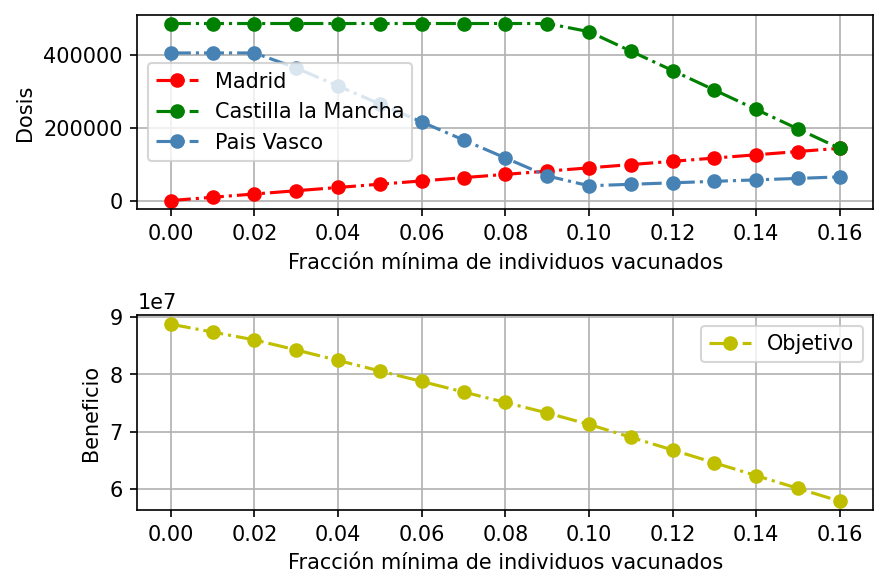

In [18]:
fig, (ax, ax2) = plt.subplots(2, 1)
fig.set_dpi(150)
ax.plot(j,Madrid,'ro-.',label='Madrid')
ax.plot(j,CastillaLaMancha,'go-.',label='Castilla la Mancha')
ax.plot(j,PaisVasco,'o-.',label='Pais Vasco', color='steelblue')
ax2.plot(j,Objetivo,'yo-.',label='Objetivo')
ax.set(xlabel='Fracción mínima de individuos vacunados', ylabel='Dosis')
ax2.set(xlabel='Fracción mínima de individuos vacunados', ylabel='Beneficio')

ax.legend()
ax.grid()
ax2.legend()
ax2.grid()


fig.tight_layout(pad=1.0)

plt.savefig("d:/Users/Usuario/Desktop/fig.svg")